Sources

*   https://www.kaggle.com/code/tauilabdelilah/person-segmentaion
*   https://github.com/qubvel/segmentation_models.pytorch#architectures
*   https://github.com/qubvel/segmentation_models.pytorch/blob/master/examples/cars%20segmentation%20(camvid).ipynb
*   https://github.com/albumentations-team/albumentations#benchmarking-results
*   https://medium.com/@oribarel/getting-the-most-out-of-your-google-colab-2b0585f82403


Set-up Directory

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/CIS-5810-Final-Project/Work/Amar_Test_Playground/peopleData.zip -d "/content"

Streaming output truncated to the last 5000 lines.
  inflating: /content/peopleData/images/ds2_person-woman-coffee-cup.png  
  inflating: /content/peopleData/images/ds2_person-woman-eyes-face.png  
  inflating: /content/peopleData/images/ds2_person-woman-hotel-laptop.png  
  inflating: /content/peopleData/images/ds2_pexels-photo-105472.png  
  inflating: /content/peopleData/images/ds2_pexels-photo-123318.png  
  inflating: /content/peopleData/images/ds2_pexels-photo-125522.png  
  inflating: /content/peopleData/images/ds2_pexels-photo-12628.png  
  inflating: /content/peopleData/images/ds2_pexels-photo-127901.png  
  inflating: /content/peopleData/images/ds2_pexels-photo-134068.png  
  inflating: /content/peopleData/images/ds2_pexels-photo-136673.png  
  inflating: /content/peopleData/images/ds2_pexels-photo-14117.png  
  inflating: /content/peopleData/images/ds2_pexels-photo-145803.png  
  inflating: /content/peopleData/images/ds2_pexels-photo-156955.png  
  inflating: /content/people

Import Libraries and Set to a GPU Device

In [ ]:
!pip install segmentation_models_pytorch
import os
import numpy as np
from PIL import Image
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import segmentation_models_pytorch as smp
import albumentations as A  
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 97 kB 3.2 MB/s 
     |████████████████████████████████| 376 kB 23.6 MB/s 
     |████████████████████████████████| 58 kB 6.4 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=516b9686929e685475344a0228abc5b335aec0fcc1d1a65d36b7806972ada9d9
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60966 sha256=8eb2d61c55c97e0ed7ec763bcb6d223e1fad6b38a106faa613a99e6fea175341
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels


Set at GPU

In [ ]:
if torch.cuda.is_available():
    print('We have a GPU!')
    DEVICE = 'cuda'
else:
    print('Sorry, CPU only.')
    DEVICE = 'cpu'

We have a GPU!


Dataloader

In [ ]:
class PeopleDataset(Dataset):
    def __init__(self, input_dir, output_dir, is_train, augmentation=None):
        self.input_dir  = input_dir
        self.output_dir = output_dir
        self.augmentation  = augmentation
        # 80:20 Training to Validation
        if is_train == True : self.images = os.listdir(input_dir)[:int(len(os.listdir(input_dir))*0.8)]
        else                : self.images = os.listdir(input_dir)[int(len(os.listdir(input_dir))*0.8):]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path    = os.path.join(self.input_dir, self.images[index])
        mask_path   = os.path.join(self.output_dir, self.images[index])
        img         = np.array(Image.open(img_path).convert("RGB"), dtype=np.float32) / 255
        mask        = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)   / 255
        
        if self.augmentation is not None:
            augmentations = self.augmentation(image=img, mask=mask)
            img   = augmentations["image"]
            mask  = augmentations["mask"]
        
        return img, mask

In [ ]:
imgs_dir = "/content/peopleData/images/"
masks_dir = "/content/peopleData/masks/"
LEARNING_RATE = 3e-4
BATCH_SIZE    = 32
NUM_EPOCHS    = 10
IMAGE_HEIGHT  = 256  
IMAGE_WIDTH   = 192

train_transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.ColorJitter(p=0.2),
        A.HorizontalFlip(p=0.5),
        ToTensorV2(),
    ],
)

val_transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        ToTensorV2(),
    ],
)
def get_loaders( inp_dir, mask_dir,batch_size,
			     train_transform, val_tranform ):
    
    train_ds     = PeopleDataset( input_dir=inp_dir, output_dir=mask_dir,
                            is_train=True, augmentation=train_transform)

    train_loader = DataLoader( train_ds, batch_size=batch_size, shuffle=True )

    val_ds       = PeopleDataset( input_dir=inp_dir, output_dir=mask_dir,
                            is_train=False, augmentation=val_transform)

    val_loader   = DataLoader( val_ds, batch_size=batch_size, shuffle=True  )

    return train_loader, val_loader

Test Dataloader

In [ ]:
# train_loader, val_loader = get_loaders( imgs_dir, masks_dir,
#                             BATCH_SIZE,  train_transform, val_transform)
# inputs, masks = next(iter(train_loader))

# _, ax = plt.subplots(1,2)
# ax[0].imshow(inputs[0].permute(1,2,0))
# ax[1].imshow(masks[0])

Helper Functions

In [ ]:
def save_checkpoint(state, filename): 
    print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])

def check_accuracy(loader, model, device="cuda"):
    num_correct = 0
    num_pixels  = 0
    dice_score  = 0

    with torch.no_grad():
        for img, mask in tqdm(loader):
            img   = img.to(device)
            mask  = mask.to(device).unsqueeze(1)
            preds = torch.sigmoid(model(img))
            preds = (preds > 0.5).float()
            num_correct += (preds == mask).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * mask).sum()) / (
                (preds + mask).sum() + 1e-7
            )

    print(
        f"Got {num_correct}/{num_pixels} with pixel accuracy {num_correct/num_pixels*100:.2f}"
    )
    print(f"Dice score: {dice_score/len(loader)*100:.2f}")

Train Model

In [ ]:
def trainModel():
  #Efficient Net scored one of the highest: https://paperswithcode.com/sota/image-classification-on-imagenet?p=res2net-a-new-multi-scale-backbone
  #DeepLabV3Plus is recommendation from Jianbo

  # model = smp.DeepLabV3Plus(encoder_name='efficientnet-b5',
  #     in_channels=3, classes=1, activation=None).to(device)
  model = smp.Unet(encoder_name='efficientnet-b3',
  in_channels=3, classes=1, activation=None).to(DEVICE)

  # Binary Cross Entropy for loss function
  criterion   = nn.BCEWithLogitsLoss()

  # High Performance Optimizer for Image Segmentation
  optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


  for e in range(NUM_EPOCHS):
    print('Epoch: ',e)
    model.train()
    loop = tqdm(train_loader)
    for i, (image, mask) in enumerate(loop):
        image = image.to(device=DEVICE)
        mask = mask.float().unsqueeze(1).to(device=DEVICE)

        # forward
        predictions = model(image)
        loss = criterion(predictions, mask)

        # backward
        model.zero_grad()
        loss.backward()
        optimizer.step()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())

    # model.eval()
    # for i, (y, x) in enumerate(tqdm(val_loader)):
    #   num_correct = 0
    #   num_pixels  = 0
    #   dice_score  = 0
    #   model.eval()

    #   with torch.no_grad():
    #       for img, mask in tqdm(val_loader):
    #           img   = img.to(device=DEVICE)
    #           mask  = mask.to(device=DEVICE).unsqueeze(1)
    #           preds = torch.sigmoid(model(img))
    #           preds = (preds > 0.5).float()
    #           num_correct += (preds == mask).sum()
    #           num_pixels += torch.numel(preds)
    #           dice_score += (2 * (preds * mask).sum()) / (
    #               (preds + mask).sum() + 1e-7
    #           )

    #   print(
    #       f"Got {num_correct}/{num_pixels} with pixel accuracy {num_correct/num_pixels*100:.2f}"
    #   )
    #   print(f"Dice score: {dice_score/len(val_loader)*100:.2f}")
  return model

train_loader, val_loader = get_loaders( imgs_dir, masks_dir,
                            BATCH_SIZE,  train_transform, val_transform)
imageSeg_model = trainModel()

Epoch:  0


100%|██████████| 67/67 [02:56<00:00,  2.64s/it, loss=0.192]


Epoch:  1


100%|██████████| 67/67 [02:58<00:00,  2.66s/it, loss=0.126]


Epoch:  2


100%|██████████| 67/67 [02:58<00:00,  2.66s/it, loss=0.094]


Epoch:  3


100%|██████████| 67/67 [02:57<00:00,  2.66s/it, loss=0.072]


Epoch:  4


100%|██████████| 67/67 [02:57<00:00,  2.65s/it, loss=0.0497]


Epoch:  5


100%|██████████| 67/67 [02:56<00:00,  2.64s/it, loss=0.0623]


Epoch:  6


100%|██████████| 67/67 [02:56<00:00,  2.64s/it, loss=0.0515]


Epoch:  7


100%|██████████| 67/67 [02:59<00:00,  2.68s/it, loss=0.0428]


Epoch:  8


100%|██████████| 67/67 [02:59<00:00,  2.68s/it, loss=0.0357]


Epoch:  9


100%|██████████| 67/67 [02:58<00:00,  2.67s/it, loss=0.0473]


IsADirectoryError: ignored

In [ ]:
# torch.save(imageSeg_model.state_dict(), "/content/drive/MyDrive/CIS-5810-Final-Project/Work/Amar_Test_Playground/model.pt")

TEST:  torch.Size([32, 3, 256, 192])


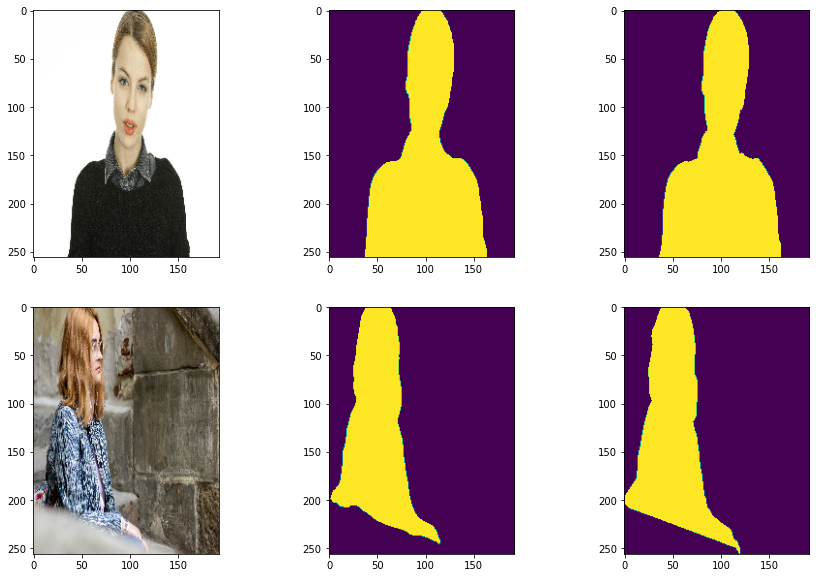

In [ ]:
inputs, masks = next(iter(val_loader))
print("TEST: ", inputs.shape)
output        = ((torch.sigmoid(imageSeg_model(inputs.to('cuda')))) >0.5).float()
_, ax = plt.subplots(2,3, figsize=(15,10))
for k in range(2):
    ax[k][0].imshow(inputs[k].permute(1,2,0))
    ax[k][1].imshow(output[k][0].cpu())
    ax[k][2].imshow(masks[k])

Image Load Process

Original Image
Original Shape:  (1800, 810, 3)
(256, 192)


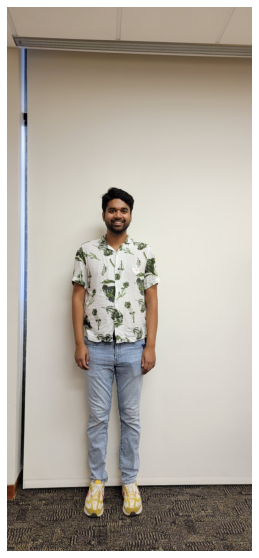

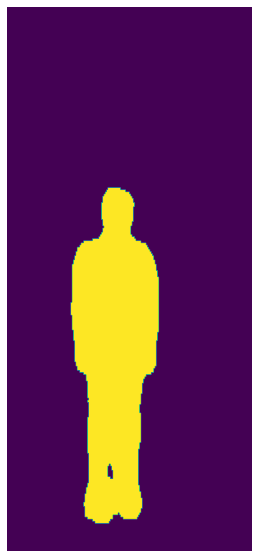

In [ ]:
import cv2
from matplotlib import pyplot as plt

imageSeg_model.eval()

def visualize(image2):
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(image2)

imgPath = '/content/drive/MyDrive/CIS-5810-Final-Project/Test_Images/Day01/Full Body/source.jpg'
image = np.array(Image.open(imgPath).convert("RGB"), dtype=np.float32) / 255
print("Original Image")
print("Original Shape: ", image.shape)
origImage = image
visualize(image)
h, w, d = image.shape
augmented_image = val_transform(image = image)['image'].to('cuda').unsqueeze(0)
output = ((torch.sigmoid(imageSeg_model(augmented_image))) >0.5).float()
mask = output.cpu()[0][0].numpy()
print(mask.shape)

mask_tf = cv2.resize(mask, (w, h), interpolation = cv2.INTER_AREA)
visualize(mask_tf)


In [ ]:
cv2.imwrite('/content/drive/MyDrive/CIS-5810-Final-Project/Test_Images/Day01/Full Body/masktf.jpg', mask_tf)

True